In [21]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [23]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 750
_C.IMAGE_H = 750
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [24]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [25]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [26]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [27]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [28]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [29]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor()])

In [30]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

30213
7629


Label: clear
mask: blur

tensor([0., 0., 0., 0.])
../data/train/blur/clear_gt/real_blur/gt_197.png


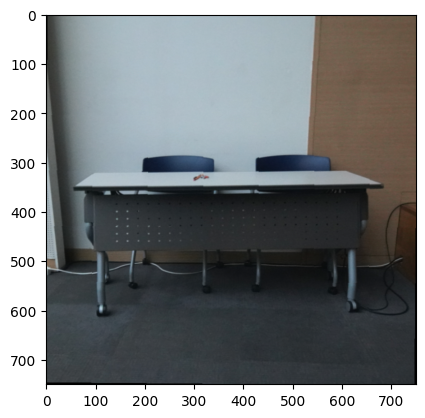

In [31]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[5000])
print(train_dataset.im_path(5000))

Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

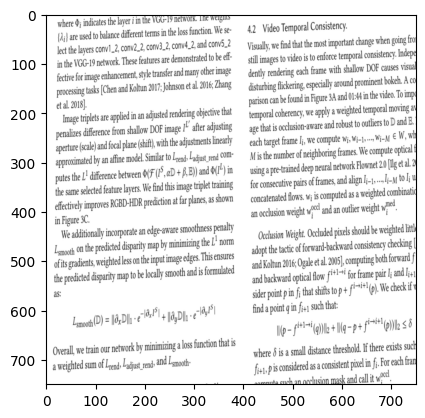

In [32]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [33]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [34]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [35]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [36]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

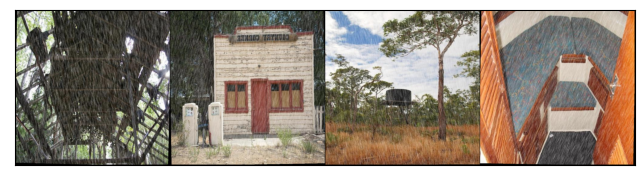

In [37]:
def show_batch(dl, nmax=16):
    for images, labels, masks in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [38]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [39]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [40]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [41]:
images, targets, masks = next(iter(val_loader))
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(1.), tensor(0.7500), tensor(0.8571))


In [42]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [43]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets, masks = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets, masks = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [45]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [46]:
# checking up the shapes of the datas
for xb, yb, masks in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 750, 750])
torch.Size([4, 4])
torch.Size([4, 4])


In [47]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [48]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 500 x 500
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 500 x 500
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 500 x 500


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 120 x 120
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 120 x 120  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 30 x 30
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 30 x 30


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 7 x 7
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 7 x 7


        self.classifier = nn.Sequential(nn.MaxPool2d(7), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = torch.sigmoid(out)
        return out

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [49]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True)
        self.model.classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [50]:
model = CustomModel().to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0
/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


803908

In [51]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 750, 750])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.5049, 0.4995, 0.5038, 0.5127],
        [0.5073, 0.4998, 0.4983, 0.5079]], device='cuda:0')


In [52]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(710934528, 12330496)

In [54]:
epochs = 10
max_lr = 0.001
grad_clip = 0.8
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [55]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.12976799056232793, rec 0.999999999999999, f2 0.22972502610491316
demoir
prec 0.15422535211267602, rec 0.6569999999999994, f2 0.24980988593125092
haze
prec 0.24690553745928334, rec 0.9474999999999992, f2 0.3917312661495427
rain
prec 0.13409359024773887, rec 0.999999999999999, f2 0.2364771151176832


[{'val_loss': 0.6998921632766724,
  'val_score': 0.26870412196473836,
  'val_score_blur': 0.22972502610491316,
  'val_score_haze': 0.3917312661495427,
  'val_score_rain': 0.2364771151176832,
  'val_score_demoir': 0.24980988593125092}]

In [56]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9923780487804863, rec 0.6575757575757569, f2 0.7910085054673204
demoir
prec 0.7199693955623561, rec 0.9409999999999991, f2 0.8157780667528676
haze
prec 0.9982728842832462, rec 0.9633333333333326, f2 0.9804919423235029
rain
prec 0.9573304157549224, rec 0.8553274682306932, f2 0.9034589571497329
Epoch [0], last_lr: 0.0003, train_loss: 0.2556, val_loss: 0.0909, val_score: 0.8785, val_score_blur: 0.7910, val_score_demoir: 0.8158, val_score_haze: 0.9805, val_score_rain: 0.9035


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8457446808510631, rec 0.9636363636363626, f2 0.9008498583564417
demoir
prec 0.7222222222222218, rec 0.974999999999999, f2 0.8297872340420637
haze
prec 0.9637972646822197, rec 0.9983333333333326, f2 0.980761358984354
rain
prec 0.9685863874345539, rec 0.9042033235581614, f2 0.9352881698680536
Epoch [1], last_lr: 0.0008, train_loss: 0.1729, val_loss: 0.0826, val_score: 0.9117, val_score_blur: 0.9008, val_score_demoir: 0.8298, val_score_haze: 0.9808, val_score_rain: 0.9353


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9097022094140241, rec 0.9565656565656556, f2 0.9325455440664615
demoir
prec 0.8218283582089545, rec 0.8809999999999991, f2 0.8503861003856001
haze
prec 0.948041566746602, rec 0.9883333333333326, f2 0.9677682578534367
rain
prec 0.8791111111111104, rec 0.9667644183773206, f2 0.9208566108002452
Epoch [2], last_lr: 0.0010, train_loss: 0.1657, val_loss: 0.0728, val_score: 0.9200, val_score_blur: 0.9325, val_score_demoir: 0.8504, val_score_haze: 0.9678, val_score_rain: 0.9209


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9399014778325113, rec 0.9636363636363626, f2 0.9516209476304217
demoir
prec 0.9246231155778882, rec 0.7359999999999992, f2 0.8195991091309086
haze
prec 0.9916107382550328, rec 0.9849999999999992, f2 0.98829431438077
rain
prec 0.9748743718592955, rec 0.9481915933528827, f2 0.9613478691769024
Epoch [3], last_lr: 0.0010, train_loss: 0.1527, val_loss: 0.0501, val_score: 0.9358, val_score_blur: 0.9516, val_score_demoir: 0.8196, val_score_haze: 0.9883, val_score_rain: 0.9613


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9745158002038726, rec 0.9656565656565647, f2 0.9700659563668252
demoir
prec 0.8152364273204897, rec 0.930999999999999, f2 0.8692810457511353
haze
prec 0.9787234042553185, rec 0.9966666666666659, f2 0.9876135425263366
rain
prec 0.9519136408243366, rec 0.9481915933528827, f2 0.950048971595973
Epoch [4], last_lr: 0.0008, train_loss: 0.1413, val_loss: 0.0432, val_score: 0.9451, val_score_blur: 0.9701, val_score_demoir: 0.8693, val_score_haze: 0.9876, val_score_rain: 0.9500


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9865563598759038, rec 0.9636363636363626, f2 0.974961676034246
demoir
prec 0.9194865810968483, rec 0.7879999999999991, f2 0.8486806677431745
haze
prec 0.9965427830596362, rec 0.9608333333333327, f2 0.9783623249888928
rain
prec 0.960435212660731, rec 0.9491691104594321, f2 0.9547689282197547
Epoch [5], last_lr: 0.0006, train_loss: 0.1300, val_loss: 0.0392, val_score: 0.9424, val_score_blur: 0.9750, val_score_demoir: 0.8487, val_score_haze: 0.9784, val_score_rain: 0.9548


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9756592292089239, rec 0.9717171717171708, f2 0.9736842105258147
demoir
prec 0.9058679706601456, rec 0.7409999999999992, f2 0.8151815181513192
haze
prec 0.9884009942004963, rec 0.9941666666666659, f2 0.9912754466135415
rain
prec 0.946601941747572, rec 0.9530791788856295, f2 0.9498295177783593
Epoch [6], last_lr: 0.0004, train_loss: 0.1168, val_loss: 0.0410, val_score: 0.9380, val_score_blur: 0.9737, val_score_demoir: 0.8152, val_score_haze: 0.9913, val_score_rain: 0.9498


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9366602687140106, rec 0.9858585858585849, f2 0.9606299212593419
demoir
prec 0.9118683901292586, rec 0.7759999999999992, f2 0.8384656942188433
haze
prec 0.995708154506437, rec 0.9666666666666659, f2 0.9809725158557361
rain
prec 0.8426395939086287, rec 0.9736070381231662, f2 0.9034013605437194
Epoch [7], last_lr: 0.0002, train_loss: 0.1033, val_loss: 0.0524, val_score: 0.9246, val_score_blur: 0.9606, val_score_demoir: 0.8385, val_score_haze: 0.9810, val_score_rain: 0.9034


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9625615763546789, rec 0.9868686868686859, f2 0.974563591021943
demoir
prec 0.8906414300736057, rec 0.8469999999999991, f2 0.8682726806760754
haze
prec 0.9949324324324317, rec 0.9816666666666659, f2 0.9882550335565462
rain
prec 0.9624134520276943, rec 0.9511241446725308, f2 0.9567354965580045
Epoch [8], last_lr: 0.0000, train_loss: 0.0933, val_loss: 0.0358, val_score: 0.9494, val_score_blur: 0.9746, val_score_demoir: 0.8683, val_score_haze: 0.9883, val_score_rain: 0.9567


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9843912591050978, rec 0.9555555555555546, f2 0.9697590978980126
demoir
prec 0.8858350951374198, rec 0.8379999999999992, f2 0.8612538540591089
haze
prec 0.97553017944535, rec 0.9966666666666659, f2 0.9859851607579495
rain
prec 0.9483253588516738, rec 0.9687194525904194, f2 0.9584139264985319
Epoch [9], last_lr: 0.0000, train_loss: 0.0879, val_loss: 0.0391, val_score: 0.9465, val_score_blur: 0.9698, val_score_demoir: 0.8613, val_score_haze: 0.9860, val_score_rain: 0.9584
CPU times: user 1h 13min 49s, sys: 12min, total: 1h 25min 50s
Wall time: 1h 49min 14s


In [57]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9635108481262318, rec 0.9868686868686859, f2 0.9750499001990999
demoir
prec 0.8632395732298731, rec 0.8899999999999991, f2 0.87641555883751
haze
prec 0.999153976311336, rec 0.984166666666666, f2 0.9916036943739744
rain
prec 0.9028776978417259, rec 0.9814271749755611, f2 0.9405152224819355
Epoch [0], last_lr: 0.0003, train_loss: 0.0927, val_loss: 0.0402, val_score: 0.9476, val_score_blur: 0.9750, val_score_demoir: 0.8764, val_score_haze: 0.9916, val_score_rain: 0.9405


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9897435897435887, rec 0.9747474747474737, f2 0.9821882951648933
demoir
prec 0.9031914893617011, rec 0.8489999999999991, f2 0.8752577319582623
haze
prec 0.9771241830065353, rec 0.9966666666666659, f2 0.986798679867486
rain
prec 0.9436485195797508, rec 0.9657869012707713, f2 0.9545893719801755
Epoch [1], last_lr: 0.0008, train_loss: 0.1125, val_loss: 0.0343, val_score: 0.9520, val_score_blur: 0.9822, val_score_demoir: 0.8753, val_score_haze: 0.9868, val_score_rain: 0.9546


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9876923076923066, rec 0.9727272727272718, f2 0.9801526717552241
demoir
prec 0.9049723756906067, rec 0.8189999999999992, f2 0.8598425196845395
haze
prec 0.9999999999999992, rec 0.9774999999999993, f2 0.9886219974710543
rain
prec 0.8906666666666659, rec 0.9794721407624624, f2 0.9329608938542489
Epoch [2], last_lr: 0.0010, train_loss: 0.1318, val_loss: 0.0416, val_score: 0.9432, val_score_blur: 0.9802, val_score_demoir: 0.8598, val_score_haze: 0.9886, val_score_rain: 0.9330


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9836065573770482, rec 0.9696969696969687, f2 0.9766022380462945
demoir
prec 0.9580419580419564, rec 0.5479999999999995, f2 0.6972010178112411
haze
prec 0.9738134206219305, rec 0.9916666666666659, f2 0.9826589595370716
rain
prec 0.988235294117646, rec 0.903225806451612, f2 0.9438202247186012
Epoch [3], last_lr: 0.0010, train_loss: 0.1342, val_loss: 0.0507, val_score: 0.9149, val_score_blur: 0.9766, val_score_demoir: 0.6972, val_score_haze: 0.9827, val_score_rain: 0.9438


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9913043478260859, rec 0.9212121212121203, f2 0.9549738219890284
demoir
prec 0.86599099099099, rec 0.7689999999999992, f2 0.8146186440672974
haze
prec 0.9933499584372395, rec 0.9958333333333326, f2 0.9945900957131903
rain
prec 0.9563924677898901, rec 0.9433040078201359, f2 0.9498031496057983
Epoch [4], last_lr: 0.0008, train_loss: 0.1320, val_loss: 0.0518, val_score: 0.9331, val_score_blur: 0.9550, val_score_demoir: 0.8146, val_score_haze: 0.9946, val_score_rain: 0.9498


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.996774193548386, rec 0.9363636363636354, f2 0.9656249999994994
demoir
prec 0.8706986444212712, rec 0.8349999999999992, f2 0.8524757529346703
haze
prec 0.9974768713204366, rec 0.9883333333333326, f2 0.9928840519040617
rain
prec 0.9575936883629181, rec 0.9491691104594321, f2 0.9533627884138338
Epoch [5], last_lr: 0.0006, train_loss: 0.1205, val_loss: 0.0415, val_score: 0.9438, val_score_blur: 0.9656, val_score_demoir: 0.8525, val_score_haze: 0.9929, val_score_rain: 0.9534


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9573412698412689, rec 0.9747474747474737, f2 0.965965965965465
demoir
prec 0.8661338661338652, rec 0.8669999999999991, f2 0.8665667166411782
haze
prec 0.9850498338870425, rec 0.9883333333333326, f2 0.9866888519129768
rain
prec 0.9414542020774307, rec 0.9745845552297155, f2 0.9577329490869152
Epoch [6], last_lr: 0.0004, train_loss: 0.1085, val_loss: 0.0430, val_score: 0.9464, val_score_blur: 0.9660, val_score_demoir: 0.8666, val_score_haze: 0.9867, val_score_rain: 0.9577


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9926160337552732, rec 0.9505050505050495, f2 0.9711042311656497
demoir
prec 0.8839662447257375, rec 0.8379999999999992, f2 0.8603696098557623
haze
prec 0.9941763727121457, rec 0.9958333333333326, f2 0.9950041631968347
rain
prec 0.9628906249999991, rec 0.9638318670576725, f2 0.963361016120652
Epoch [7], last_lr: 0.0002, train_loss: 0.0967, val_loss: 0.0367, val_score: 0.9502, val_score_blur: 0.9711, val_score_demoir: 0.8604, val_score_haze: 0.9950, val_score_rain: 0.9634


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9855818743563326, rec 0.9666666666666657, f2 0.9760326364094938
demoir
prec 0.8870431893687698, rec 0.8009999999999992, f2 0.8418286915391746
haze
prec 0.9983193277310917, rec 0.9899999999999992, f2 0.9941422594137251
rain
prec 0.9549808429118766, rec 0.9745845552297155, f2 0.964683115626011
Epoch [8], last_lr: 0.0000, train_loss: 0.0912, val_loss: 0.0395, val_score: 0.9477, val_score_blur: 0.9760, val_score_demoir: 0.8418, val_score_haze: 0.9941, val_score_rain: 0.9647


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.982897384305834, rec 0.9868686868686859, f2 0.9848790322575633
demoir
prec 0.929181929181928, rec 0.7609999999999992, f2 0.8367234744360075
haze
prec 0.9949958298582144, rec 0.9941666666666659, f2 0.9945810754476027
rain
prec 0.9285714285714278, rec 0.978494623655913, f2 0.952879581151332
Epoch [9], last_lr: 0.0000, train_loss: 0.0850, val_loss: 0.0375, val_score: 0.9471, val_score_blur: 0.9849, val_score_demoir: 0.8367, val_score_haze: 0.9946, val_score_rain: 0.9529


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9907407407407397, rec 0.9727272727272718, f2 0.9816513761462881
demoir
prec 0.89468196037539, rec 0.8579999999999991, f2 0.8759571209795911
haze
prec 0.9947871416159854, rec 0.9541666666666659, f2 0.974053594214727
rain
prec 0.9602713178294565, rec 0.9687194525904194, f2 0.9644768856442679
Epoch [0], last_lr: 0.0003, train_loss: 0.0890, val_loss: 0.0357, val_score: 0.9504, val_score_blur: 0.9817, val_score_demoir: 0.8760, val_score_haze: 0.9741, val_score_rain: 0.9645


  0%|          | 0/7554 [00:00<?, ?it/s]

OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/berezerker/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/berezerker/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_23938/2812108042.py", line 16, in __getitem__
    img = self.transform(img)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 346, in forward
    return F.resize(img, self.size, self.interpolation, self.max_size, self.antialias)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py", line 474, in resize
    return F_pil.resize(img, size=output_size, interpolation=pil_interpolation)
  File "/home/berezerker/.local/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py", line 252, in resize
    return img.resize(tuple(size[::-1]), interpolation)
  File "/home/berezerker/.local/lib/python3.8/site-packages/PIL/Image.py", line 2079, in resize
    self.load()
  File "/home/berezerker/.local/lib/python3.8/site-packages/PIL/ImageFile.py", line 242, in load
    s = read(self.decodermaxblock)
  File "/home/berezerker/.local/lib/python3.8/site-packages/PIL/JpegImagePlugin.py", line 403, in load_read
    s = self.fp.read(read_bytes)
OSError: [Errno 12] Cannot allocate memory


In [58]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.99371727748691, rec 0.9585858585858575, f2 0.9758354755779053
demoir
prec 0.926190476190475, rec 0.7779999999999992, f2 0.8456521739125462
haze
prec 0.9843363561417965, rec 0.9949999999999992, f2 0.9896394529626158
rain
prec 0.9577603143418458, rec 0.9530791788856295, f2 0.9554140127383525


{'val_loss': 0.03802487626671791,
 'val_score': 0.9457458429416046,
 'val_score_blur': 0.9758354755779053,
 'val_score_haze': 0.9896394529626158,
 'val_score_rain': 0.9554140127383525,
 'val_score_demoir': 0.8456521739125462}

Label: clear
mask: blur

tensor([9.7258e-03, 1.7226e-03, 3.5814e-05, 5.9669e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


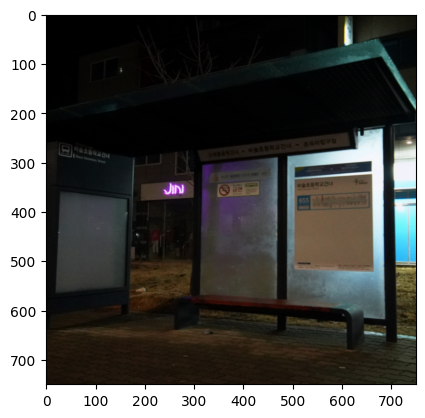

In [76]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, mask)
predict_single(*val_dataset[1497])

In [60]:
val_dataset.im_path(1497)

'../data/test/blur/clear_gt/real_blur/gt_489.png'

In [41]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

0
3
8
9
10
12
13
15
16
18
22
24
25
28
32
33
34
38
46
48
49
53
59
61
65
66
67
69
71
72
73
75
76
77
82
83
86
87
89
91
92
93
94
96
98
108
114
118
121
127
132
134
138
140
141
148
151
163
253
255
329
334
339
413
414
417
428
431
433
434
435
437
438
442
443
446
448
472
473
477
479
488
561
629
636
645
649
652
674
676
704
733
755
758
764
766
767
770
772
833
897
898
899
906
907
910
914
922
923
953
961
980
984
991
992
996
997
1004
1007
1009
1015
1016
1017
1018
1020
1022
1026
1032
1034
1037
1041
1042
1046
1047
1053
1054
1060
1130
1140
1141
1191
1192
1193
1194
1196
1198
1200
1201
1202
1205
1207
1209
1211
1287
1311
1323
1327
1342
1345
1346
1348
1349
1355
1356
1361
1363
1364
1368
1369
1370
1379
1384
1397
1398
1399
1421
1460
1462
1465
1476
1487
1510
1521
1532
1587
1632
1635
1645
1646
1671
1674
1676
1678
1680
1681
1682
1684
1688
1690
1691
1709
1716
1718
1721
1722
1723
1724
1726
1733
1735
1878
1879
1889
1905
1906
1907
1956
1961
1963
1971
1973
1974
2044
2045
2048
2049
2050
2052
2053
2056
2057
2058
2062
2

Label: blur
mask: blur

tensor([9.7242e-01, 1.5999e-03, 6.0036e-05, 1.9625e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


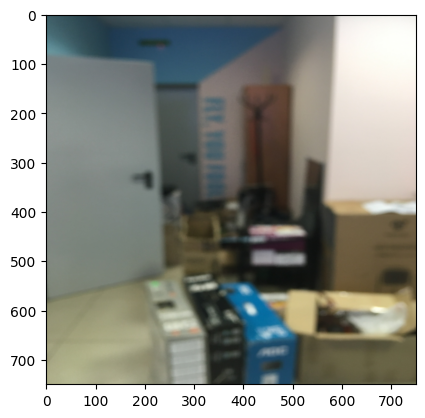

In [61]:
predict_single(*val_dataset[0])

In [62]:
val_dataset.im_path(0)

'../data/test/blur/0_IPHONE-SE_F.JPG'

Label: clear
mask: blur

tensor([0., 0., 0., 0.])


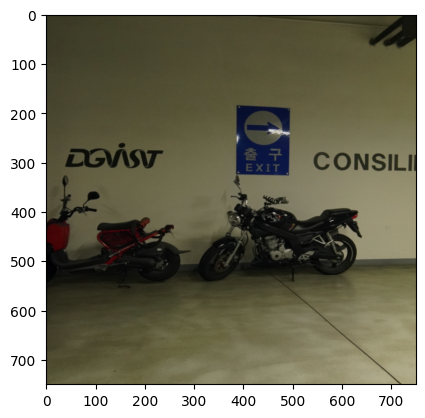

In [63]:
show_example(*val_dataset[1258])

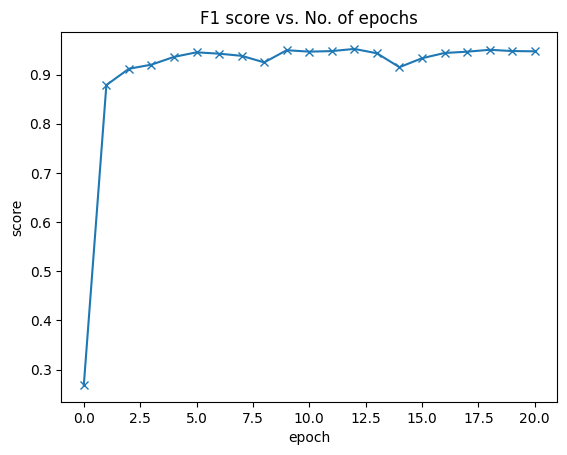

In [64]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

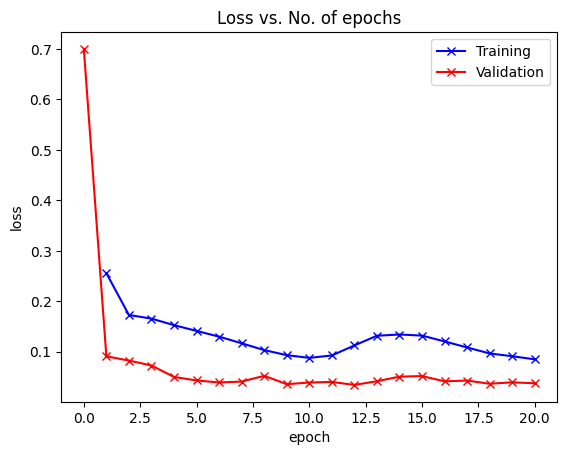

In [65]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

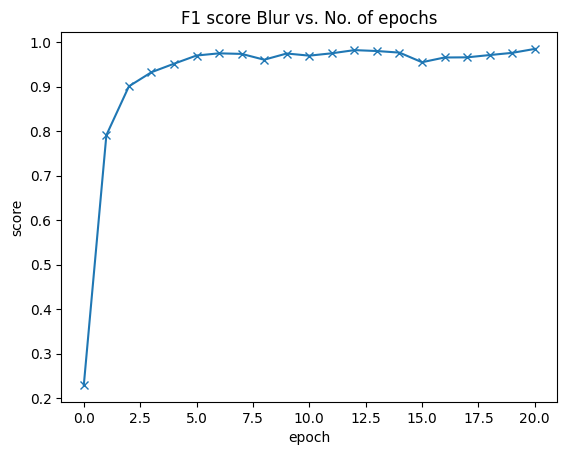

In [66]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

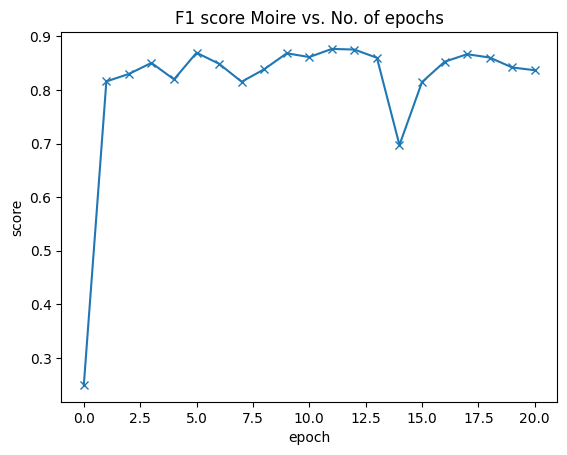

In [67]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

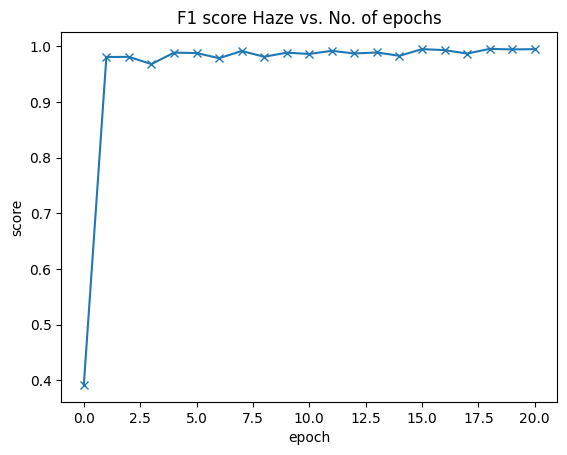

In [68]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

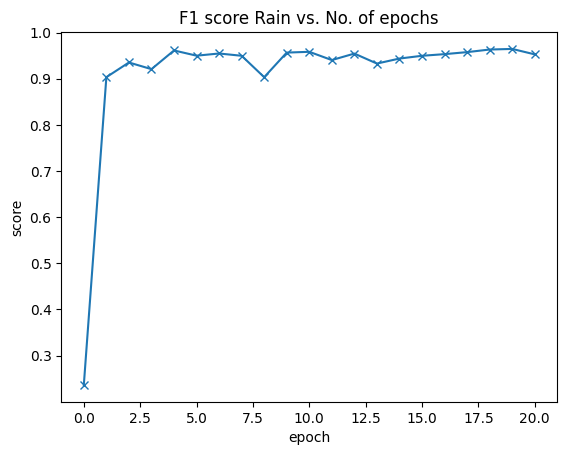

In [69]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

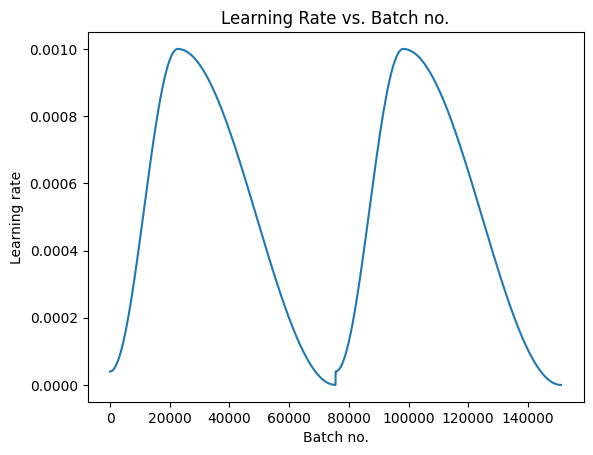

In [70]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [71]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([7.2775e-07, 1.8434e-05, 4.5235e-01, 5.4079e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


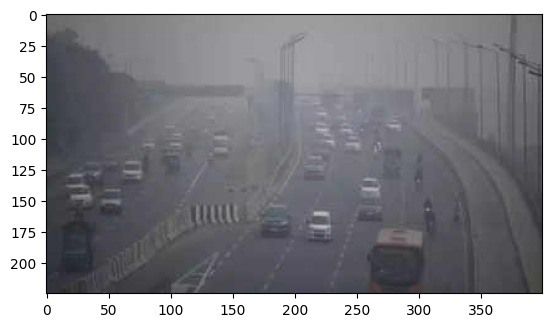

In [72]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([6.4549e-04, 1.6205e-01, 1.1158e-04, 2.3468e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


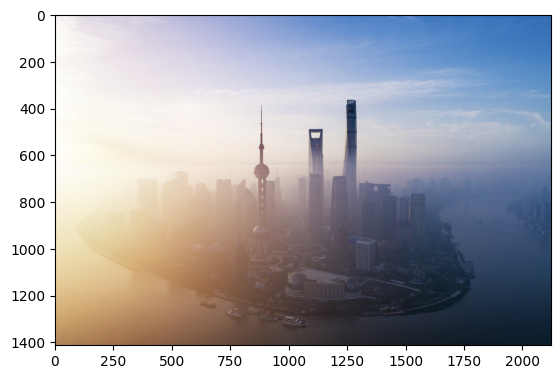

In [73]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.0008, 0.1118, 0.0001, 0.0225], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


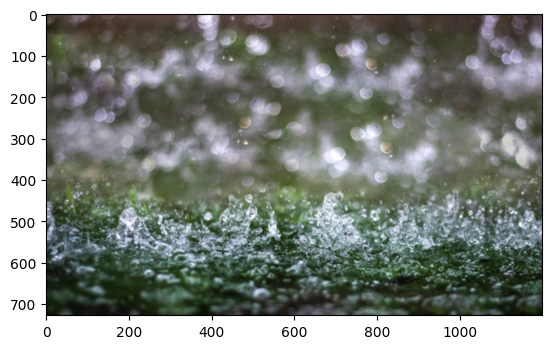

In [74]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

In [77]:
PATH = os.path.join('../saved_models', datetime.now().strftime('mobilenetv2_full_data_750_14_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()